In [1]:
import warnings
warnings.filterwarnings('ignore')
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
from tsxv.splitTrainValTest import split_train_val_test_forwardChaining
import matplotlib.pyplot as plt
import optuna
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv('BrentOilPrices.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.resample('M').mean()
data = data.reset_index()

In [3]:
input_train, forecast_train, input_val, forecast_val, input_test, forecast_test = split_train_val_test_forwardChaining(
    data['Date'], numInputs=60, numOutputs=24, numJumps=24)
data = data.set_index('Date')
data.index.freq = 'M'

## FBProphet

FBProphet uses a decomposable additive time series model with three main model components: trend, seasonality, and holidays. 

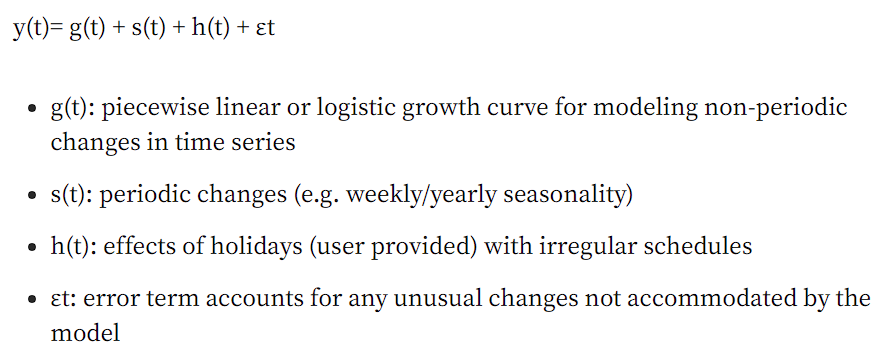

<b>Assumptions of FBProphet</b>: No assumptions required

<b>Advantages of FBProphet</b>:
1. Simple to use and easy to interpret
2. Highly tunable with hyperparameter tuning

<b>Disadvantages of FBProphet</b>:
1. Data needs to be in a specific format (column names)
2. Higher variation of performance by data set

<b>Important hyperparameters of FBProphet</b>:
1. changepoint_prior_scale: Sets how much trend changes at different trend changepoints. Setting too small value results in trend underfitting, otherwise setting too large value results in trend overfitting. Recommended range of values is between 0.001 and 0.5.

2. seasonality_prior_scale: Sets flexibility of seasonality to fit fluctuations. Setting small value shrinks magnitude of seasonality, while setting large value allows seasonality to fit large fluctuations. Recommended range of values is between 0.01 and 10.

3. holidays_prior_scale: Sets flexibility of holiday effects to fit fluctuations. Recommended range of values is between 0.01 and 10.

4. seasonality_mode: Sets mode of seasonality to use.

In [4]:
def prophet_objective(trial, train_data, val_data=None):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10, log=True)
    seasonality_mode = trial.suggest_categorical('seasonality_mode',['additive','multiplicative'])
    reg = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, 
                  holidays_prior_scale=holidays_prior_scale,seasonality_mode=seasonality_mode)
    train_data_copy = train_data.reset_index().copy()
    train_data_copy.columns = ['ds', 'y']
    reg.fit(train_data_copy)
    if val_data is not None:
        future = pd.DataFrame(val_data.reset_index()['Date'])
        future.columns = ['ds']
        forecast = reg.predict(future)
        val_mape = mean_absolute_percentage_error(val_data,forecast['yhat'])
    else:
        future = pd.DataFrame(train_data.reset_index()['Date'])
        future.columns = ['ds']
        forecast = reg.predict(future)
        val_mape = mean_absolute_percentage_error(train_data,forecast['yhat'])
    return val_mape

In [5]:
avg_val_mape, avg_test_mape = [], []
for fold in range(len(input_train)):
    input_sub_train_data = data.loc[list(input_train[fold].ravel())].drop_duplicates()
    input_sub_train_data.index.freq = 'M'
    input_sub_val_data = data.loc[list(input_val[fold].ravel())].drop_duplicates()
    input_sub_val_data.index.freq = 'M'
    input_sub_test_data = data.loc[list(input_test[fold].ravel())].drop_duplicates()
    input_sub_test_data.index.freq = 'M'
    func = lambda trial: prophet_objective(trial, input_sub_train_data, input_sub_val_data)
    sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
    study = optuna.create_study(direction='minimize',sampler=sampler)
    study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
    trial = study.best_trial
    reg = Prophet(changepoint_prior_scale=trial.params['changepoint_prior_scale'], 
                  seasonality_prior_scale=trial.params['seasonality_prior_scale'], 
                  holidays_prior_scale=trial.params['holidays_prior_scale'],
                 seasonality_mode = trial.params['seasonality_mode'])
    train_val_data = pd.concat([input_sub_train_data,input_sub_val_data]).reset_index()
    train_val_data.columns = ['ds', 'y']
    reg.fit(train_val_data)
    future = pd.DataFrame(input_sub_test_data.reset_index()['Date'])
    future.columns = ['ds']
    forecast = reg.predict(future)
    test_mape = mean_absolute_percentage_error(input_sub_test_data,forecast['yhat'])
    print()
    print(f'Best hyperparameters identified for fold {fold+1}: {trial.params}')
    print(f'Validation MAPE for fold {fold+1} : {trial.value}')
    print(f'Test MAPE for fold {fold+1} : {test_mape}')
    print()
    avg_val_mape.append(trial.value)
    avg_test_mape.append(test_mape)
print('---------')
print(f'Average validation MAPE: {np.mean(avg_val_mape)}')
print(f'Average test MAPE: {np.mean(avg_test_mape)}')

[I 2022-11-12 10:07:05,096] A new study created in memory with name: no-name-d697f045-a850-4f04-a746-110c4ec23b76


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 10:07:06,047] Trial 0 finished with value: 0.24469093201566658 and parameters: {'changepoint_prior_scale': 0.06757432074659307, 'seasonality_prior_scale': 0.3458409430528475, 'holidays_prior_scale': 0.7432195672632871, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.24469093201566658.
[I 2022-11-12 10:07:07,438] Trial 1 finished with value: 0.5298582255806352 and parameters: {'changepoint_prior_scale': 0.36843064950949167, 'seasonality_prior_scale': 8.989319101761044, 'holidays_prior_scale': 3.658201619571844, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.24469093201566658.
[I 2022-11-12 10:07:08,107] Trial 2 finished with value: 0.20833484819922962 and parameters: {'changepoint_prior_scale': 0.005106251350915423, 'seasonality_prior_scale': 0.015821430175348976, 'holidays_prior_scale': 0.8725795276524484, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.20833484819922962.
[I 2022-11-12 10:07:09,411] Trial 3 finished with value

[I 2022-11-12 10:07:23,416] A new study created in memory with name: no-name-53ce052e-ac80-420a-9f20-cedbe06275fb



Best hyperparameters identified for fold 1: {'changepoint_prior_scale': 0.042001662704291204, 'seasonality_prior_scale': 0.01608789806578356, 'holidays_prior_scale': 0.12518895292965615, 'seasonality_mode': 'additive'}
Validation MAPE for fold 1 : 0.14779485112968382
Test MAPE for fold 1 : 0.3948658060439716



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 10:07:23,924] Trial 0 finished with value: 0.29880420810251956 and parameters: {'changepoint_prior_scale': 0.06757432074659307, 'seasonality_prior_scale': 0.3458409430528475, 'holidays_prior_scale': 0.7432195672632871, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.29880420810251956.
[I 2022-11-12 10:07:24,407] Trial 1 finished with value: 0.2791872886351084 and parameters: {'changepoint_prior_scale': 0.36843064950949167, 'seasonality_prior_scale': 8.989319101761044, 'holidays_prior_scale': 3.658201619571844, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 0.2791872886351084.
[I 2022-11-12 10:07:24,864] Trial 2 finished with value: 0.2654585830529651 and parameters: {'changepoint_prior_scale': 0.005106251350915423, 'seasonality_prior_scale': 0.015821430175348976, 'holidays_prior_scale': 0.8725795276524484, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.2654585830529651.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:25,353] Trial 3 finished with value: 0.27838505130906266 and parameters: {'changepoint_prior_scale': 0.372294203306687, 'seasonality_prior_scale': 0.611550441408745, 'holidays_prior_scale': 9.627612801528926, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.2654585830529651.
[I 2022-11-12 10:07:26,086] Trial 4 finished with value: 0.26564866094423834 and parameters: {'changepoint_prior_scale': 0.0023972268893483317, 'seasonality_prior_scale': 0.04186344546544307, 'holidays_prior_scale': 0.3285354397749122, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.2654585830529651.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:26,541] Trial 5 finished with value: 0.26516758631280524 and parameters: {'changepoint_prior_scale': 0.004252264721146147, 'seasonality_prior_scale': 0.6553965378213311, 'holidays_prior_scale': 1.2843198269917597, 'seasonality_mode': 'multiplicative'}. Best is trial 5 with value: 0.26516758631280524.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:27,234] Trial 6 finished with value: 0.266162598388851 and parameters: {'changepoint_prior_scale': 0.0026854744500763982, 'seasonality_prior_scale': 8.315862479456571, 'holidays_prior_scale': 1.351326848162046, 'seasonality_mode': 'multiplicative'}. Best is trial 5 with value: 0.26516758631280524.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:27,898] Trial 7 finished with value: 0.26627799107750166 and parameters: {'changepoint_prior_scale': 0.002423615271807224, 'seasonality_prior_scale': 0.02097191997272446, 'holidays_prior_scale': 0.7124195911059706, 'seasonality_mode': 'additive'}. Best is trial 5 with value: 0.26516758631280524.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:28,607] Trial 8 finished with value: 0.26507330110138255 and parameters: {'changepoint_prior_scale': 0.0019349743762223002, 'seasonality_prior_scale': 0.10428115365700466, 'holidays_prior_scale': 0.06123121581624542, 'seasonality_mode': 'additive'}. Best is trial 8 with value: 0.26507330110138255.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:29,323] Trial 9 finished with value: 0.2659810642538206 and parameters: {'changepoint_prior_scale': 0.0014392567942961819, 'seasonality_prior_scale': 2.8194527800863054, 'holidays_prior_scale': 0.23454341925495364, 'seasonality_mode': 'multiplicative'}. Best is trial 8 with value: 0.26507330110138255.
[I 2022-11-12 10:07:30,080] Trial 10 finished with value: 0.2652724237753854 and parameters: {'changepoint_prior_scale': 0.002375340169057392, 'seasonality_prior_scale': 0.04832932245158315, 'holidays_prior_scale': 0.015647784699211426, 'seasonality_mode': 'additive'}. Best is trial 8 with value: 0.26507330110138255.
[I 2022-11-12 10:07:30,559] Trial 11 finished with value: 0.2659481861818422 and parameters: {'changepoint_prior_scale': 0.008368682477337725, 'seasonality_prior_scale': 0.8300657879682551, 'holidays_prior_scale': 8.262914136470327, 'seasonality_mode': 'multiplicative'}. Best is trial 8 with value: 0.26507330110138255.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:31,041] Trial 12 finished with value: 0.2662965828976698 and parameters: {'changepoint_prior_scale': 0.02196368669772143, 'seasonality_prior_scale': 0.10621513745799577, 'holidays_prior_scale': 0.07637840206993197, 'seasonality_mode': 'multiplicative'}. Best is trial 8 with value: 0.26507330110138255.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:31,720] Trial 13 finished with value: 0.2656677982831645 and parameters: {'changepoint_prior_scale': 0.002281058309439725, 'seasonality_prior_scale': 0.1655729503168603, 'holidays_prior_scale': 1.0151400188744846, 'seasonality_mode': 'multiplicative'}. Best is trial 8 with value: 0.26507330110138255.
[I 2022-11-12 10:07:32,456] Trial 14 finished with value: 0.26550165310925083 and parameters: {'changepoint_prior_scale': 0.002467322224580344, 'seasonality_prior_scale': 0.5611052826848645, 'holidays_prior_scale': 0.09875935454249915, 'seasonality_mode': 'additive'}. Best is trial 8 with value: 0.26507330110138255.
[I 2022-11-12 10:07:32,939] Trial 15 finished with value: 0.2647615817590846 and parameters: {'changepoint_prior_scale': 0.024121825146283592, 'seasonality_prior_scale': 3.6266445580180737, 'holidays_prior_scale': 0.09379053285822313, 'seasonality_mode': 'multiplicative'}. Best is trial 15 with value: 0.2647615817590846.
[I 2022-11-12 10:07:33,414] Trial 16 

Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:33,887] Trial 17 finished with value: 0.2656582767473058 and parameters: {'changepoint_prior_scale': 0.030076578726006848, 'seasonality_prior_scale': 4.728317955377171, 'holidays_prior_scale': 0.1367498259820385, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2647615817590846.
[I 2022-11-12 10:07:34,600] Trial 18 finished with value: 0.26533771423223246 and parameters: {'changepoint_prior_scale': 0.001526907566736026, 'seasonality_prior_scale': 0.2468214066364891, 'holidays_prior_scale': 0.01244005741042131, 'seasonality_mode': 'multiplicative'}. Best is trial 15 with value: 0.2647615817590846.
[I 2022-11-12 10:07:35,084] Trial 19 finished with value: 0.30311854316713105 and parameters: {'changepoint_prior_scale': 0.10043549155080156, 'seasonality_prior_scale': 0.03344183035714717, 'holidays_prior_scale': 0.027286551260031325, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.2647615817590846.


[I 2022-11-12 10:07:35,575] A new study created in memory with name: no-name-8acc2ec9-0440-42dd-b9e7-f3da0446e96d



Best hyperparameters identified for fold 2: {'changepoint_prior_scale': 0.024121825146283592, 'seasonality_prior_scale': 3.6266445580180737, 'holidays_prior_scale': 0.09379053285822313, 'seasonality_mode': 'multiplicative'}
Validation MAPE for fold 2 : 0.2647615817590846
Test MAPE for fold 2 : 0.35431444880600477



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 10:07:36,068] Trial 0 finished with value: 0.3465055056154404 and parameters: {'changepoint_prior_scale': 0.06757432074659307, 'seasonality_prior_scale': 0.3458409430528475, 'holidays_prior_scale': 0.7432195672632871, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.3465055056154404.
[I 2022-11-12 10:07:36,546] Trial 1 finished with value: 0.3562678568116526 and parameters: {'changepoint_prior_scale': 0.36843064950949167, 'seasonality_prior_scale': 8.989319101761044, 'holidays_prior_scale': 3.658201619571844, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.3465055056154404.
[I 2022-11-12 10:07:37,027] Trial 2 finished with value: 0.3601608404797875 and parameters: {'changepoint_prior_scale': 0.005106251350915423, 'seasonality_prior_scale': 0.015821430175348976, 'holidays_prior_scale': 0.8725795276524484, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.3465055056154404.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:37,501] Trial 3 finished with value: 0.35764737008528574 and parameters: {'changepoint_prior_scale': 0.372294203306687, 'seasonality_prior_scale': 0.611550441408745, 'holidays_prior_scale': 9.627612801528926, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.3465055056154404.
[I 2022-11-12 10:07:38,274] Trial 4 finished with value: 0.32081549915022833 and parameters: {'changepoint_prior_scale': 0.0023972268893483317, 'seasonality_prior_scale': 0.04186344546544307, 'holidays_prior_scale': 0.3285354397749122, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 0.32081549915022833.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:38,749] Trial 5 finished with value: 0.349919416156073 and parameters: {'changepoint_prior_scale': 0.004252264721146147, 'seasonality_prior_scale': 0.6553965378213311, 'holidays_prior_scale': 1.2843198269917597, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 0.32081549915022833.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:39,511] Trial 6 finished with value: 0.3221988159172058 and parameters: {'changepoint_prior_scale': 0.0026854744500763982, 'seasonality_prior_scale': 8.315862479456571, 'holidays_prior_scale': 1.351326848162046, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 0.32081549915022833.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:40,227] Trial 7 finished with value: 0.3211941915566488 and parameters: {'changepoint_prior_scale': 0.002423615271807224, 'seasonality_prior_scale': 0.02097191997272446, 'holidays_prior_scale': 0.7124195911059706, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 0.32081549915022833.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:41,037] Trial 8 finished with value: 0.31983932090312717 and parameters: {'changepoint_prior_scale': 0.0019349743762223002, 'seasonality_prior_scale': 0.10428115365700466, 'holidays_prior_scale': 0.06123121581624542, 'seasonality_mode': 'additive'}. Best is trial 8 with value: 0.31983932090312717.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:41,935] Trial 9 finished with value: 0.32077922116211505 and parameters: {'changepoint_prior_scale': 0.0014392567942961819, 'seasonality_prior_scale': 2.8194527800863054, 'holidays_prior_scale': 0.23454341925495364, 'seasonality_mode': 'multiplicative'}. Best is trial 8 with value: 0.31983932090312717.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:42,717] Trial 10 finished with value: 0.32071222591197157 and parameters: {'changepoint_prior_scale': 0.002375340169057392, 'seasonality_prior_scale': 0.04832932245158315, 'holidays_prior_scale': 0.015647784699211426, 'seasonality_mode': 'additive'}. Best is trial 8 with value: 0.31983932090312717.
[I 2022-11-12 10:07:43,544] Trial 11 finished with value: 0.3198716527863309 and parameters: {'changepoint_prior_scale': 0.002953829682417114, 'seasonality_prior_scale': 0.2602096667130579, 'holidays_prior_scale': 0.01933893175980486, 'seasonality_mode': 'additive'}. Best is trial 8 with value: 0.31983932090312717.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:44,027] Trial 12 finished with value: 0.32226507093763046 and parameters: {'changepoint_prior_scale': 0.010852632435901458, 'seasonality_prior_scale': 0.37104109786588646, 'holidays_prior_scale': 0.0784342625147693, 'seasonality_mode': 'additive'}. Best is trial 8 with value: 0.31983932090312717.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:45,035] Trial 13 finished with value: 0.31942772093085486 and parameters: {'changepoint_prior_scale': 0.0016603544433401425, 'seasonality_prior_scale': 0.6614556970284757, 'holidays_prior_scale': 0.05300013286810284, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.31942772093085486.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:45,847] Trial 14 finished with value: 0.3198146091340316 and parameters: {'changepoint_prior_scale': 0.0017680268249483427, 'seasonality_prior_scale': 0.4067282885593904, 'holidays_prior_scale': 0.27396029718835846, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.31942772093085486.
[I 2022-11-12 10:07:46,571] Trial 15 finished with value: 0.3190995994122198 and parameters: {'changepoint_prior_scale': 0.0015748781008236342, 'seasonality_prior_scale': 0.750979756655258, 'holidays_prior_scale': 0.2786978807455227, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.3190995994122198.
[I 2022-11-12 10:07:47,052] Trial 16 finished with value: 0.359105798132956 and parameters: {'changepoint_prior_scale': 0.00508397067900512, 'seasonality_prior_scale': 3.314659463877517, 'holidays_prior_scale': 0.014060148111802508, 'seasonality_mode': 'multiplicative'}. Best is trial 15 with value: 0.3190995994122198.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:47,523] Trial 17 finished with value: 0.32244553327880987 and parameters: {'changepoint_prior_scale': 0.026894736909311115, 'seasonality_prior_scale': 8.722415316671363, 'holidays_prior_scale': 0.12290900570529978, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.3190995994122198.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:48,326] Trial 18 finished with value: 0.32082838746629944 and parameters: {'changepoint_prior_scale': 0.0027488694029559526, 'seasonality_prior_scale': 4.362537783375098, 'holidays_prior_scale': 0.03193152255607997, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.3190995994122198.
[I 2022-11-12 10:07:49,079] Trial 19 finished with value: 0.3209882658503561 and parameters: {'changepoint_prior_scale': 0.0017419555729178047, 'seasonality_prior_scale': 4.748650924173725, 'holidays_prior_scale': 0.4150766397322147, 'seasonality_mode': 'additive'}. Best is trial 15 with value: 0.3190995994122198.


[I 2022-11-12 10:07:49,550] A new study created in memory with name: no-name-d64f60ed-5a86-4dc7-9bb2-b607abfe3c90



Best hyperparameters identified for fold 3: {'changepoint_prior_scale': 0.0015748781008236342, 'seasonality_prior_scale': 0.750979756655258, 'holidays_prior_scale': 0.2786978807455227, 'seasonality_mode': 'additive'}
Validation MAPE for fold 3 : 0.3190995994122198
Test MAPE for fold 3 : 0.5673409827278693



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 10:07:50,075] Trial 0 finished with value: 0.39578053334617447 and parameters: {'changepoint_prior_scale': 0.06757432074659307, 'seasonality_prior_scale': 0.3458409430528475, 'holidays_prior_scale': 0.7432195672632871, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.39578053334617447.
[I 2022-11-12 10:07:50,560] Trial 1 finished with value: 0.32360025780614937 and parameters: {'changepoint_prior_scale': 0.36843064950949167, 'seasonality_prior_scale': 8.989319101761044, 'holidays_prior_scale': 3.658201619571844, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 0.32360025780614937.
[I 2022-11-12 10:07:51,008] Trial 2 finished with value: 0.31854550900761297 and parameters: {'changepoint_prior_scale': 0.005106251350915423, 'seasonality_prior_scale': 0.015821430175348976, 'holidays_prior_scale': 0.8725795276524484, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.31854550900761297.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:51,481] Trial 3 finished with value: 0.3138018501535588 and parameters: {'changepoint_prior_scale': 0.372294203306687, 'seasonality_prior_scale': 0.611550441408745, 'holidays_prior_scale': 9.627612801528926, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 0.3138018501535588.
[I 2022-11-12 10:07:52,261] Trial 4 finished with value: 0.38438470157631316 and parameters: {'changepoint_prior_scale': 0.0023972268893483317, 'seasonality_prior_scale': 0.04186344546544307, 'holidays_prior_scale': 0.3285354397749122, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 0.3138018501535588.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:52,717] Trial 5 finished with value: 0.32989577844630613 and parameters: {'changepoint_prior_scale': 0.004252264721146147, 'seasonality_prior_scale': 0.6553965378213311, 'holidays_prior_scale': 1.2843198269917597, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 0.3138018501535588.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:53,467] Trial 6 finished with value: 0.3838399078535524 and parameters: {'changepoint_prior_scale': 0.0026854744500763982, 'seasonality_prior_scale': 8.315862479456571, 'holidays_prior_scale': 1.351326848162046, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 0.3138018501535588.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:54,216] Trial 7 finished with value: 0.38433014566234386 and parameters: {'changepoint_prior_scale': 0.002423615271807224, 'seasonality_prior_scale': 0.02097191997272446, 'holidays_prior_scale': 0.7124195911059706, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 0.3138018501535588.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:07:54,979] Trial 8 finished with value: 0.3845392205161819 and parameters: {'changepoint_prior_scale': 0.0019349743762223002, 'seasonality_prior_scale': 0.10428115365700466, 'holidays_prior_scale': 0.06123121581624542, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 0.3138018501535588.
[I 2022-11-12 10:07:55,742] Trial 9 finished with value: 0.383645381766676 and parameters: {'changepoint_prior_scale': 0.0014392567942961819, 'seasonality_prior_scale': 2.8194527800863054, 'holidays_prior_scale': 0.23454341925495364, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 0.3138018501535588.
[I 2022-11-12 10:07:56,240] Trial 10 finished with value: 0.32025170308040923 and parameters: {'changepoint_prior_scale': 0.2675886605049578, 'seasonality_prior_scale': 0.027771608276323523, 'holidays_prior_scale': 2.2352423416437426, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 0.3138018501535588.
[I 2022-11-12 10:07:56,719] Trial 11 finished 

[I 2022-11-12 10:08:01,010] A new study created in memory with name: no-name-4008473c-5666-4941-a223-1567922e4d4e



Best hyperparameters identified for fold 4: {'changepoint_prior_scale': 0.48717018323857136, 'seasonality_prior_scale': 9.784195264347552, 'holidays_prior_scale': 0.2575532421351618, 'seasonality_mode': 'multiplicative'}
Validation MAPE for fold 4 : 0.26530825695257065
Test MAPE for fold 4 : 0.23467185868229928



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 10:08:01,506] Trial 0 finished with value: 0.2946624455693589 and parameters: {'changepoint_prior_scale': 0.06757432074659307, 'seasonality_prior_scale': 0.3458409430528475, 'holidays_prior_scale': 0.7432195672632871, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.2946624455693589.
[I 2022-11-12 10:08:02,004] Trial 1 finished with value: 0.22075776079150908 and parameters: {'changepoint_prior_scale': 0.36843064950949167, 'seasonality_prior_scale': 8.989319101761044, 'holidays_prior_scale': 3.658201619571844, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 0.22075776079150908.
[I 2022-11-12 10:08:02,459] Trial 2 finished with value: 0.43014417911868547 and parameters: {'changepoint_prior_scale': 0.005106251350915423, 'seasonality_prior_scale': 0.015821430175348976, 'holidays_prior_scale': 0.8725795276524484, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 0.22075776079150908.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:02,921] Trial 3 finished with value: 0.21242041041713963 and parameters: {'changepoint_prior_scale': 0.372294203306687, 'seasonality_prior_scale': 0.611550441408745, 'holidays_prior_scale': 9.627612801528926, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 0.21242041041713963.
[I 2022-11-12 10:08:03,756] Trial 4 finished with value: 0.4377055975047914 and parameters: {'changepoint_prior_scale': 0.0023972268893483317, 'seasonality_prior_scale': 0.04186344546544307, 'holidays_prior_scale': 0.3285354397749122, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 0.21242041041713963.
[I 2022-11-12 10:08:04,200] Trial 5 finished with value: 0.42795034695637135 and parameters: {'changepoint_prior_scale': 0.004252264721146147, 'seasonality_prior_scale': 0.6553965378213311, 'holidays_prior_scale': 1.2843198269917597, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 0.21242041041713963.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:04,640] Trial 6 finished with value: 0.4452836574827475 and parameters: {'changepoint_prior_scale': 0.0026854744500763982, 'seasonality_prior_scale': 8.315862479456571, 'holidays_prior_scale': 1.351326848162046, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 0.21242041041713963.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:05,485] Trial 7 finished with value: 0.4379403950972635 and parameters: {'changepoint_prior_scale': 0.002423615271807224, 'seasonality_prior_scale': 0.02097191997272446, 'holidays_prior_scale': 0.7124195911059706, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 0.21242041041713963.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:06,338] Trial 8 finished with value: 0.43785147002127434 and parameters: {'changepoint_prior_scale': 0.0019349743762223002, 'seasonality_prior_scale': 0.10428115365700466, 'holidays_prior_scale': 0.06123121581624542, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 0.21242041041713963.
[I 2022-11-12 10:08:07,175] Trial 9 finished with value: 0.4366707254750265 and parameters: {'changepoint_prior_scale': 0.0014392567942961819, 'seasonality_prior_scale': 2.8194527800863054, 'holidays_prior_scale': 0.23454341925495364, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 0.21242041041713963.
[I 2022-11-12 10:08:07,660] Trial 10 finished with value: 0.2255684811667415 and parameters: {'changepoint_prior_scale': 0.2675886605049578, 'seasonality_prior_scale': 0.027771608276323523, 'holidays_prior_scale': 2.2352423416437426, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 0.21242041041713963.
[I 2022-11-12 10:08:08,134] Trial 11 finis

[I 2022-11-12 10:08:12,473] A new study created in memory with name: no-name-7a7b2e0c-a29b-4f69-ad70-727795bef49a



Best hyperparameters identified for fold 5: {'changepoint_prior_scale': 0.46004767481139924, 'seasonality_prior_scale': 0.19641258256948632, 'holidays_prior_scale': 7.942384013891772, 'seasonality_mode': 'additive'}
Validation MAPE for fold 5 : 0.2085544479970997
Test MAPE for fold 5 : 0.28693111971727525



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 10:08:12,967] Trial 0 finished with value: 0.4165734015157114 and parameters: {'changepoint_prior_scale': 0.06757432074659307, 'seasonality_prior_scale': 0.3458409430528475, 'holidays_prior_scale': 0.7432195672632871, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.4165734015157114.
[I 2022-11-12 10:08:13,446] Trial 1 finished with value: 0.4589993590746789 and parameters: {'changepoint_prior_scale': 0.36843064950949167, 'seasonality_prior_scale': 8.989319101761044, 'holidays_prior_scale': 3.658201619571844, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.4165734015157114.
[I 2022-11-12 10:08:13,902] Trial 2 finished with value: 0.5444898934810483 and parameters: {'changepoint_prior_scale': 0.005106251350915423, 'seasonality_prior_scale': 0.015821430175348976, 'holidays_prior_scale': 0.8725795276524484, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.4165734015157114.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:14,386] Trial 3 finished with value: 0.46073784473631824 and parameters: {'changepoint_prior_scale': 0.372294203306687, 'seasonality_prior_scale': 0.611550441408745, 'holidays_prior_scale': 9.627612801528926, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.4165734015157114.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:15,330] Trial 4 finished with value: 0.5611633217320583 and parameters: {'changepoint_prior_scale': 0.0023972268893483317, 'seasonality_prior_scale': 0.04186344546544307, 'holidays_prior_scale': 0.3285354397749122, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.4165734015157114.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:16,449] Trial 5 finished with value: 0.557442681540202 and parameters: {'changepoint_prior_scale': 0.004252264721146147, 'seasonality_prior_scale': 0.6553965378213311, 'holidays_prior_scale': 1.2843198269917597, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.4165734015157114.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:17,361] Trial 6 finished with value: 0.56119247065294 and parameters: {'changepoint_prior_scale': 0.0026854744500763982, 'seasonality_prior_scale': 8.315862479456571, 'holidays_prior_scale': 1.351326848162046, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.4165734015157114.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:18,341] Trial 7 finished with value: 0.5563106649009261 and parameters: {'changepoint_prior_scale': 0.002423615271807224, 'seasonality_prior_scale': 0.02097191997272446, 'holidays_prior_scale': 0.7124195911059706, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.4165734015157114.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:19,195] Trial 8 finished with value: 0.5599141567670842 and parameters: {'changepoint_prior_scale': 0.0019349743762223002, 'seasonality_prior_scale': 0.10428115365700466, 'holidays_prior_scale': 0.06123121581624542, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.4165734015157114.
[I 2022-11-12 10:08:20,093] Trial 9 finished with value: 0.5613520055292652 and parameters: {'changepoint_prior_scale': 0.0014392567942961819, 'seasonality_prior_scale': 2.8194527800863054, 'holidays_prior_scale': 0.23454341925495364, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.4165734015157114.
[I 2022-11-12 10:08:20,598] Trial 10 finished with value: 0.4371418130337821 and parameters: {'changepoint_prior_scale': 0.29472228826773345, 'seasonality_prior_scale': 0.12480401527534717, 'holidays_prior_scale': 0.16204927535072045, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.4165734015157114.
[I 2022-11-12 10:08:21,121] Trial 11 finished

[I 2022-11-12 10:08:25,386] A new study created in memory with name: no-name-c05d32dd-a77b-4c1e-845e-52299faeeb1d



Best hyperparameters identified for fold 6: {'changepoint_prior_scale': 0.13255443402987874, 'seasonality_prior_scale': 0.011909676544731919, 'holidays_prior_scale': 0.6293303977815303, 'seasonality_mode': 'additive'}
Validation MAPE for fold 6 : 0.3941543062615328
Test MAPE for fold 6 : 0.1895905569217489



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 10:08:25,868] Trial 0 finished with value: 0.22493215270604183 and parameters: {'changepoint_prior_scale': 0.06757432074659307, 'seasonality_prior_scale': 0.3458409430528475, 'holidays_prior_scale': 0.7432195672632871, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.22493215270604183.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:26,379] Trial 1 finished with value: 0.3007665286202087 and parameters: {'changepoint_prior_scale': 0.36843064950949167, 'seasonality_prior_scale': 8.989319101761044, 'holidays_prior_scale': 3.658201619571844, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.22493215270604183.
[I 2022-11-12 10:08:27,473] Trial 2 finished with value: 0.45460003922859465 and parameters: {'changepoint_prior_scale': 0.005106251350915423, 'seasonality_prior_scale': 0.015821430175348976, 'holidays_prior_scale': 0.8725795276524484, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.22493215270604183.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:28,002] Trial 3 finished with value: 0.30025134878087384 and parameters: {'changepoint_prior_scale': 0.372294203306687, 'seasonality_prior_scale': 0.611550441408745, 'holidays_prior_scale': 9.627612801528926, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.22493215270604183.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:29,156] Trial 4 finished with value: 0.45453959285064344 and parameters: {'changepoint_prior_scale': 0.0023972268893483317, 'seasonality_prior_scale': 0.04186344546544307, 'holidays_prior_scale': 0.3285354397749122, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.22493215270604183.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:30,154] Trial 5 finished with value: 0.45499413519760873 and parameters: {'changepoint_prior_scale': 0.004252264721146147, 'seasonality_prior_scale': 0.6553965378213311, 'holidays_prior_scale': 1.2843198269917597, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.22493215270604183.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:31,171] Trial 6 finished with value: 0.4531890187836868 and parameters: {'changepoint_prior_scale': 0.0026854744500763982, 'seasonality_prior_scale': 8.315862479456571, 'holidays_prior_scale': 1.351326848162046, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.22493215270604183.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:32,148] Trial 7 finished with value: 0.4546082683598041 and parameters: {'changepoint_prior_scale': 0.002423615271807224, 'seasonality_prior_scale': 0.02097191997272446, 'holidays_prior_scale': 0.7124195911059706, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.22493215270604183.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:33,067] Trial 8 finished with value: 0.4555970070954406 and parameters: {'changepoint_prior_scale': 0.0019349743762223002, 'seasonality_prior_scale': 0.10428115365700466, 'holidays_prior_scale': 0.06123121581624542, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.22493215270604183.
[I 2022-11-12 10:08:34,105] Trial 9 finished with value: 0.45358467591901447 and parameters: {'changepoint_prior_scale': 0.0014392567942961819, 'seasonality_prior_scale': 2.8194527800863054, 'holidays_prior_scale': 0.23454341925495364, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.22493215270604183.
[I 2022-11-12 10:08:34,639] Trial 10 finished with value: 0.29763195038152773 and parameters: {'changepoint_prior_scale': 0.29472228826773345, 'seasonality_prior_scale': 0.12480401527534717, 'holidays_prior_scale': 0.16204927535072045, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.22493215270604183.
[I 2022-11-12 10:08:35,159] Trial 11 fin

[I 2022-11-12 10:08:39,506] A new study created in memory with name: no-name-58ef2ea8-f513-42a4-920b-89e25208d760



Best hyperparameters identified for fold 7: {'changepoint_prior_scale': 0.038047418832126506, 'seasonality_prior_scale': 0.7384318435046178, 'holidays_prior_scale': 0.2665762429519919, 'seasonality_mode': 'additive'}
Validation MAPE for fold 7 : 0.2076572081489377
Test MAPE for fold 7 : 0.5474242281779738



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 10:08:39,994] Trial 0 finished with value: 0.39646331392845835 and parameters: {'changepoint_prior_scale': 0.06757432074659307, 'seasonality_prior_scale': 0.3458409430528475, 'holidays_prior_scale': 0.7432195672632871, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.39646331392845835.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:40,496] Trial 1 finished with value: 0.4403163438877727 and parameters: {'changepoint_prior_scale': 0.36843064950949167, 'seasonality_prior_scale': 8.989319101761044, 'holidays_prior_scale': 3.658201619571844, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.39646331392845835.
[I 2022-11-12 10:08:42,108] Trial 2 finished with value: 0.3585151301832575 and parameters: {'changepoint_prior_scale': 0.005106251350915423, 'seasonality_prior_scale': 0.015821430175348976, 'holidays_prior_scale': 0.8725795276524484, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.3585151301832575.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:42,603] Trial 3 finished with value: 0.4398324137748686 and parameters: {'changepoint_prior_scale': 0.372294203306687, 'seasonality_prior_scale': 0.611550441408745, 'holidays_prior_scale': 9.627612801528926, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.3585151301832575.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:43,673] Trial 4 finished with value: 0.35804883517289193 and parameters: {'changepoint_prior_scale': 0.0023972268893483317, 'seasonality_prior_scale': 0.04186344546544307, 'holidays_prior_scale': 0.3285354397749122, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 0.35804883517289193.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:45,170] Trial 5 finished with value: 0.3606888984677079 and parameters: {'changepoint_prior_scale': 0.004252264721146147, 'seasonality_prior_scale': 0.6553965378213311, 'holidays_prior_scale': 1.2843198269917597, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 0.35804883517289193.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:46,383] Trial 6 finished with value: 0.36080244581219495 and parameters: {'changepoint_prior_scale': 0.0026854744500763982, 'seasonality_prior_scale': 8.315862479456571, 'holidays_prior_scale': 1.351326848162046, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 0.35804883517289193.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:47,652] Trial 7 finished with value: 0.35935879868935866 and parameters: {'changepoint_prior_scale': 0.002423615271807224, 'seasonality_prior_scale': 0.02097191997272446, 'holidays_prior_scale': 0.7124195911059706, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 0.35804883517289193.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:48,767] Trial 8 finished with value: 0.3593346547343594 and parameters: {'changepoint_prior_scale': 0.0019349743762223002, 'seasonality_prior_scale': 0.10428115365700466, 'holidays_prior_scale': 0.06123121581624542, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 0.35804883517289193.
[I 2022-11-12 10:08:49,722] Trial 9 finished with value: 0.35979085108895037 and parameters: {'changepoint_prior_scale': 0.0014392567942961819, 'seasonality_prior_scale': 2.8194527800863054, 'holidays_prior_scale': 0.23454341925495364, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 0.35804883517289193.
[I 2022-11-12 10:08:50,185] Trial 10 finished with value: 0.28162919648209145 and parameters: {'changepoint_prior_scale': 0.017273721239878012, 'seasonality_prior_scale': 0.019981504831163344, 'holidays_prior_scale': 0.03862421659071689, 'seasonality_mode': 'additive'}. Best is trial 10 with value: 0.28162919648209145.
[I 2022-11-12 10:08:50,668] Trial 11 

Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:53,551] Trial 17 finished with value: 0.39358409858406357 and parameters: {'changepoint_prior_scale': 0.061099968540588155, 'seasonality_prior_scale': 0.011726153015878822, 'holidays_prior_scale': 0.019920389984808235, 'seasonality_mode': 'multiplicative'}. Best is trial 15 with value: 0.2203549636633689.


Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:08:54,843] Trial 18 finished with value: 0.360768306359509 and parameters: {'changepoint_prior_scale': 0.0042506420399738565, 'seasonality_prior_scale': 0.056633867038356295, 'holidays_prior_scale': 0.010891709738502613, 'seasonality_mode': 'multiplicative'}. Best is trial 15 with value: 0.2203549636633689.
[I 2022-11-12 10:08:55,957] Trial 19 finished with value: 0.35889188505170005 and parameters: {'changepoint_prior_scale': 0.002717183807399984, 'seasonality_prior_scale': 0.010738797391536783, 'holidays_prior_scale': 0.19756003588747859, 'seasonality_mode': 'multiplicative'}. Best is trial 15 with value: 0.2203549636633689.

Best hyperparameters identified for fold 8: {'changepoint_prior_scale': 0.013074542964011941, 'seasonality_prior_scale': 0.013078991795696273, 'holidays_prior_scale': 0.2322370114804837, 'seasonality_mode': 'multiplicative'}
Validation MAPE for fold 8 : 0.2203549636633689
Test MAPE for fold 8 : 1.1537298441140798

---------
Average validation MA

In [6]:
func = lambda trial: prophet_objective(trial, data)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial

[I 2022-11-12 10:08:56,458] A new study created in memory with name: no-name-a6e480f4-ec68-4f2f-b55e-8587318384a7


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 10:08:57,046] Trial 0 finished with value: 0.2168932010635288 and parameters: {'changepoint_prior_scale': 0.06757432074659307, 'seasonality_prior_scale': 0.3458409430528475, 'holidays_prior_scale': 0.7432195672632871, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.2168932010635288.
[I 2022-11-12 10:08:57,623] Trial 1 finished with value: 0.200958761192427 and parameters: {'changepoint_prior_scale': 0.36843064950949167, 'seasonality_prior_scale': 8.989319101761044, 'holidays_prior_scale': 3.658201619571844, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 0.200958761192427.
[I 2022-11-12 10:08:58,136] Trial 2 finished with value: 0.45036664238476665 and parameters: {'changepoint_prior_scale': 0.005106251350915423, 'seasonality_prior_scale': 0.015821430175348976, 'holidays_prior_scale': 0.8725795276524484, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 0.200958761192427.
[I 2022-11-12 10:08:58,709] Trial 3 finished with value: 0.200

Optimization terminated abnormally. Falling back to Newton.


[I 2022-11-12 10:09:01,307] Trial 8 finished with value: 0.6784170665196512 and parameters: {'changepoint_prior_scale': 0.0019349743762223002, 'seasonality_prior_scale': 0.10428115365700466, 'holidays_prior_scale': 0.06123121581624542, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 0.20050379356218292.
[I 2022-11-12 10:09:02,696] Trial 9 finished with value: 0.45287945219923953 and parameters: {'changepoint_prior_scale': 0.0014392567942961819, 'seasonality_prior_scale': 2.8194527800863054, 'holidays_prior_scale': 0.23454341925495364, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 0.20050379356218292.
[I 2022-11-12 10:09:03,340] Trial 10 finished with value: 0.19926769495618207 and parameters: {'changepoint_prior_scale': 0.2675886605049578, 'seasonality_prior_scale': 0.027771608276323523, 'holidays_prior_scale': 2.2352423416437426, 'seasonality_mode': 'additive'}. Best is trial 10 with value: 0.19926769495618207.
[I 2022-11-12 10:09:03,967] Trial 11 fin

In [7]:
reg =  Prophet(changepoint_prior_scale=trial.params['changepoint_prior_scale'], 
               seasonality_prior_scale=trial.params['seasonality_prior_scale'], 
               holidays_prior_scale=trial.params['holidays_prior_scale'],
              seasonality_mode=trial.params['seasonality_mode'])
data_copy = data.reset_index()
data_copy.columns = ['ds', 'y']
reg.fit(data_copy)
future = pd.DataFrame(data.reset_index()['Date'])
future.columns = ['ds']
forecast = reg.predict(future)
pred_values = forecast['yhat'].values

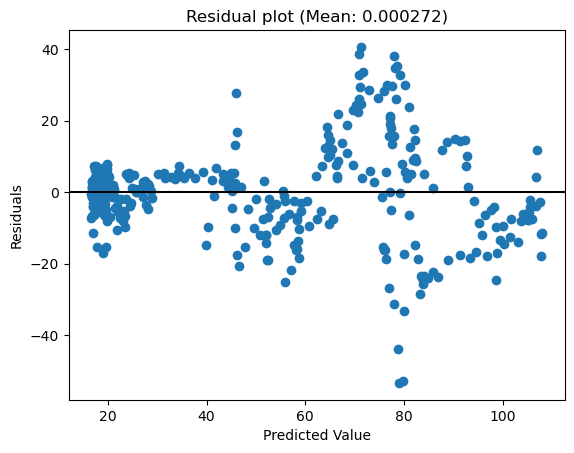

In [8]:
plt.scatter(x = pred_values, y= np.subtract(pred_values,data['Price']))
plt.axhline(y=0, color='black')
plt.title(f"Residual plot (Mean: {np.round(np.subtract(pred_values,data['Price']).mean(),6)})")
plt.ylabel('Residuals')
plt.xlabel('Predicted Value')
plt.show()

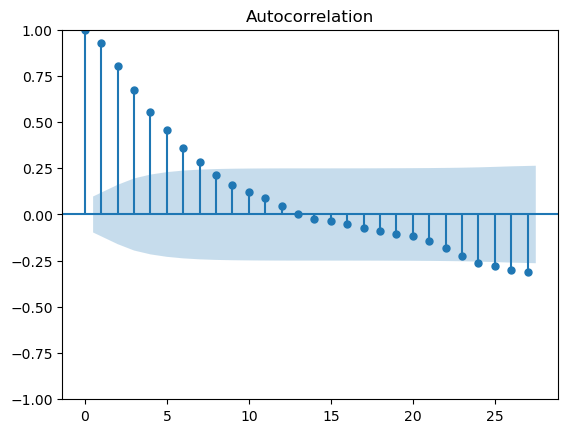

array([ 1.        ,  0.92677709,  0.80352058,  0.67352739,  0.55659154,
        0.45552256,  0.36240995,  0.28335456,  0.21329341,  0.15860143,
        0.12349847,  0.08920928,  0.04646442,  0.0049234 , -0.02418678,
       -0.03763731, -0.05384014, -0.07332531, -0.0914016 , -0.10327038,
       -0.11883488, -0.14374577, -0.17924809, -0.22381786, -0.26193114,
       -0.2811621 , -0.29989174])

In [9]:
plot_acf(np.subtract(pred_values,data['Price']))
plt.show()
acf(np.subtract(pred_values,data['Price']))

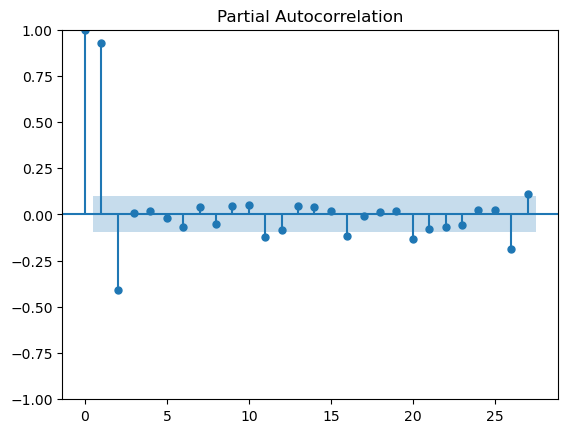

array([ 1.        ,  0.92907109, -0.40682655,  0.00943563,  0.02057409,
       -0.01719623, -0.07023865,  0.03961673, -0.05242793,  0.04760939,
        0.05045165, -0.12078313, -0.08169269,  0.0451425 ,  0.03837227,
        0.01912447, -0.11633679, -0.00780117,  0.01557581,  0.01821385,
       -0.13171851, -0.07974239, -0.06848569, -0.05672071,  0.02424702,
        0.02378063, -0.18614968])

In [10]:
plot_pacf(np.subtract(pred_values,data['Price']))
plt.show()
pacf(np.subtract(pred_values,data['Price']))

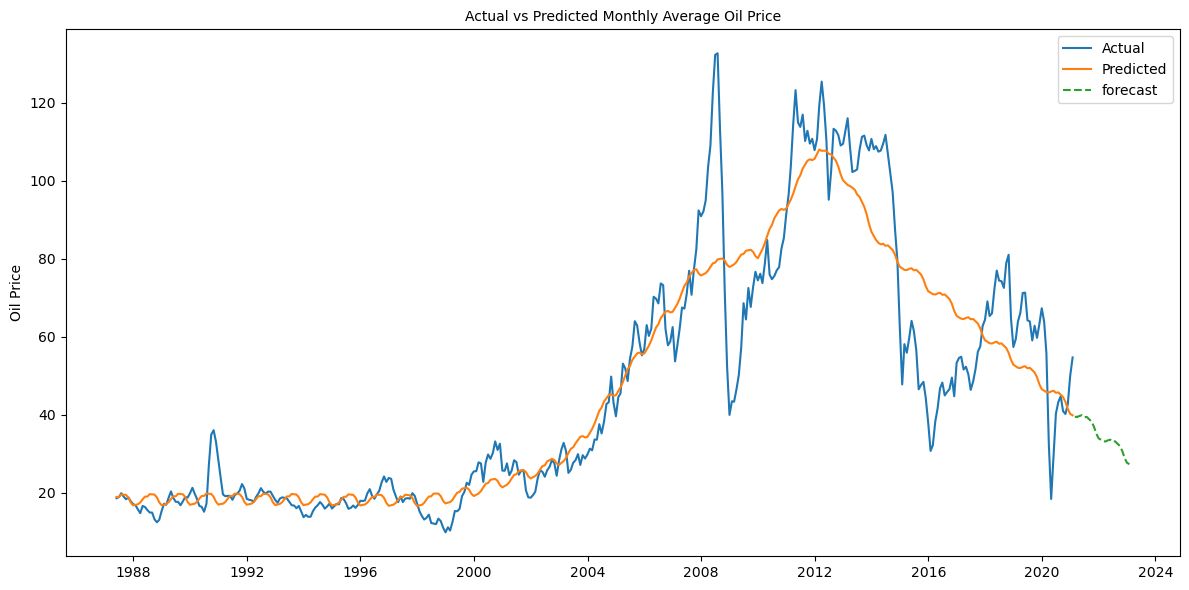

In [11]:
plt.figure(figsize=(12,6))
plt.plot(data, label='Actual')
plt.title('Actual vs Predicted Monthly Average Oil Price', fontsize=10)
pred_data = pd.DataFrame({'Date':data.reset_index()['Date'],'Price': pred_values})
pred_data['Date'] = pd.to_datetime(pred_data['Date'])
pred_data = pred_data.set_index('Date')
plt.plot(pred_data, label='Predicted')
future = reg.make_future_dataframe(24,freq='M',include_history=False)
forecast = reg.predict(future)
predicted_value = forecast[['ds','yhat']]
predicted_value.columns = ['Date','Price']
predicted_value = predicted_value.set_index('Date')
plt.plot(predicted_value, label='forecast',linestyle='--')
plt.legend(loc='best')
plt.ylabel("Oil Price")
plt.tight_layout()

In [12]:
def sarima_objective(trial, train_data, val_data=None):
    p = trial.suggest_int('p',0,2)
    q = trial.suggest_int('q',0,2)
    trend = trial.suggest_categorical('trend',['n','c','t','ct'])
    reg = SARIMAX(endog=train_data, order=(p,1,q), initialization='approximate_diffuse', freq='M',trend=trend, seasonal_order=(p,1,q,12))
    reg = reg.fit(disp=0, maxiter=1000)
    if val_data is not None:
        yhat = reg.forecast(len(val_data))
        val_mape = mean_absolute_percentage_error(val_data,yhat)
    else:
        yhat = reg.predict(start=0, end=len(train_data)-1)
        val_mape = mean_absolute_percentage_error(train_data,yhat)
    return val_mape

In [13]:
avg_val_mape, avg_test_mape = [], []
for fold in range(len(input_train)):
    input_sub_train_data = data.loc[list(input_train[fold].ravel())].drop_duplicates()
    input_sub_train_data.index.freq = 'M'
    input_sub_val_data = data.loc[list(input_val[fold].ravel())].drop_duplicates()
    input_sub_val_data.index.freq = 'M'
    input_sub_test_data = data.loc[list(input_test[fold].ravel())].drop_duplicates()
    input_sub_test_data.index.freq = 'M'
    func = lambda trial: sarima_objective(trial, input_sub_train_data, input_sub_val_data)
    sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
    study = optuna.create_study(direction='minimize',sampler=sampler)
    study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
    trial = study.best_trial
    reg = SARIMAX(endog=pd.concat([input_sub_train_data,input_sub_val_data]), order=(trial.params['p'],1,trial.params['q']), 
                  initialization='approximate_diffuse', freq='M',trend=trial.params['trend'], seasonal_order=(trial.params['p'],1,trial.params['q'],12))
    reg = reg.fit(disp=0, maxiter=1000)
    yhat = reg.forecast(len(input_sub_test_data))
    test_mape = mean_absolute_percentage_error(input_sub_test_data,yhat)
    print()
    print(f'Best hyperparameters identified for fold {fold+1}: {trial.params}')
    print(f'Validation MAPE for fold {fold+1} : {trial.value}')
    print(f'Test MAPE for fold {fold+1} : {test_mape}')
    print()
    avg_val_mape.append(trial.value)
    avg_test_mape.append(test_mape)
print('---------')
print(f'Average validation MAPE: {np.mean(avg_val_mape)}')
print(f'Average test MAPE: {np.mean(avg_test_mape)}')

[I 2022-11-12 10:09:10,832] A new study created in memory with name: no-name-89c3fdbe-0fee-42a1-9618-c7b8963a6967


  0%|          | 0/20 [00:00<?, ?it/s]

[W 2022-11-12 10:09:10,862] Trial 0 failed because of the following error: NameError("name 'SARIMAX' is not defined")
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_11464/3115918516.py", line 9, in <lambda>
    func = lambda trial: sarima_objective(trial, input_sub_train_data, input_sub_val_data)
  File "/tmp/ipykernel_11464/998180498.py", line 5, in sarima_objective
    reg = SARIMAX(endog=train_data, order=(p,1,q), initialization='approximate_diffuse', freq='M',trend=trend, seasonal_order=(p,1,q,12))
NameError: name 'SARIMAX' is not defined


NameError: name 'SARIMAX' is not defined

In [ ]:
func = lambda trial: sarima_objective(trial, data)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial

In [ ]:
reg = SARIMAX(endog=data, order=(trial.params['p'],1,trial.params['q']), initialization='approximate_diffuse', freq='M', seasonal_order=(trial.params['p'],1,trial.params['q'],12))
reg = reg.fit(disp=0, maxiter=1000)
pred_values = reg.predict(start=0, end=len(data)-1)

In [ ]:
plt.scatter(x = pred_values, y= np.subtract(pred_values,data['Price']))
plt.axhline(y=0, color='black')
plt.title(f"Residual plot (Mean: {np.round(np.subtract(pred_values,data['Price']).mean(),6)})")
plt.ylabel('Residuals')
plt.xlabel('Predicted Value')
plt.show()

In [ ]:
plot_acf(np.subtract(pred_values,data['Price']))
plt.show()
acf(np.subtract(pred_values,data['Price']))

In [ ]:
plot_pacf(np.subtract(pred_values,data['Price']))
plt.show()
pacf(np.subtract(pred_values,data['Price']))

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data, label='Actual')
plt.title('Actual vs Predicted Monthly Average Oil Price', fontsize=10)
pred_data = pd.DataFrame({'Date':data.reset_index()['Date'],'Price': pd.Series(pred_values.reset_index(drop=True))})
pred_data['Date'] = pd.to_datetime(pred_data['Date'])
pred_data = pred_data.set_index('Date')
plt.plot(pred_data, label='Predicted')
forecast_data = reg.forecast(24)
plt.plot(forecast_data, label='forecast',linestyle='--')
plt.legend(loc='best')
plt.ylabel("Oil Price")
plt.tight_layout()